# Setup

In [1]:
# General libraries
import pandas as pd
import numpy as np
import warnings
import lightgbm
import gc
import os

# Plots
from matplotlib import pyplot as plt

# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import mutual_info_regression

# Forecaster
from lightgbm import LGBMRegressor

# Multiprocessing
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
from functools import partial

# Plots
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython import display
from time import sleep
from math import ceil

# Cuda
import torch

# Pd options
pd.set_option('display.max_columns', None)

In [2]:
# Suppress warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Suppress the specific PerformanceWarning
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None

In [3]:
# Get the number of available CPUs
num_cpus = os.cpu_count()

# Show
print(num_cpus)

8


In [4]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
else:
    print("CUDA is not available. Using CPU.")

CUDA is not available. Using CPU.


# Directory

In [5]:
# Set cd to parent directory
os.chdir("/Users/ignasipascual/Documents/GitHub/LightGBM-Forecaster")
cwd = os.getcwd()
print("Current Working Directory:", cwd)

Current Working Directory: /Users/ignasipascual/Documents/GitHub/LightGBM-Forecaster


In [6]:
# Set source
source = 'local'

# Print files in directory
if source == 'gdrive':
    # Use directory from gdrive
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Forecasting')
    print("Listing files from Google Drive 'Forecasting' directory:")
    # Drivers for cuda
    !mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
    # Google colab options
    # Google
    from google.colab import output
    output.no_vertical_scroll()
else:
    print("Listing files from the current local directory:")

# List files in the specified directory
files = os.listdir()

# Print each file
for file in files:
    print(file)

Listing files from the current local directory:
.DS_Store
LICENSE
requirements.txt
utils
docs
README.md
submissions
.git
data
notebooks


# Assets

## Import assets

In [7]:
# Import assets
from utils.forecaster import Forecaster
from utils.evaluator import Evaluator
from utils.auxiliar import *

# Load data

In [8]:
# Create the filename with the phase appended
file_name = f'Data/df_backtesting.csv'

# Read the CSV file
df_input = pd.read_csv(file_name)

# Show
df_input.head()

/var/folders/l5/tnjkfgnd2qldj4yfpgl07fkc0000gn/T/ipykernel_2961/778183082.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_input = pd.read_csv(file_name)


,client,warehouse,product,id_column,date,sales,price,filled_sales,filled_price,cutoff,sample,feature_client,feature_warehouse,feature_product,feature_id_column,feature_periods,feature_periods_expanding,feature_periods_sqrt,feature_year,feature_quarter,feature_month,feature_week,feature_weeks_until_next_end_of_quarter,feature_weeks_until_end_of_year,feature_months_until_next_end_of_quarter,feature_months_until_end_of_year,filled_sales_ma_4,filled_sales_ma_13,filled_price_ma_4,filled_price_ma_13,filled_sales_min_13,filled_sales_max_13,filled_price_min_13,filled_price_max_13,feature_filled_sales_lag_13,feature_filled_sales_lag_52,feature_filled_price_lag_13,feature_filled_price_lag_52,feature_filled_sales_ma_4_lag_13,feature_filled_sales_ma_4_lag_52,feature_filled_price_ma_4_lag_13,feature_filled_price_ma_4_lag_52,feature_filled_sales_ma_13_lag_13,feature_filled_sales_ma_13_lag_52,feature_filled_price_ma_13_lag_13,feature_filled_price_ma_13_lag_52,feature_filled_sales_min_13_lag_13,feature_filled_sales_min_13_lag_52,feature_filled_sales_max_13_lag_13,feature_filled_sales_max_13_lag_52,feature_filled_sales_cov,feature_distinct_product_client,feature_distinct_product_warehouse,feature_distinct_product_cutoff,feature_filled_sales_cluster,feature_filled_price_cluster,feature_periods_history_cluster,feature_intermittence_filled_sales_cluster,train_weight,feature_baseline_filled_sales_ma_13,feature_baseline_filled_price_ma_13,baseline_filled_sales_ma_13,baseline_filled_price_ma_13,baseline_filled_price_lgbm,feature_baseline_filled_price_lgbm
0,1,235,10012,1/235/10012,2020-07-06,0.0,NaN,0.0,NaN,2023-11-06,train,0,10,3,33,0.0,0.0,0.0,2020,3,7,28,12,25,2,5,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.83,1,2,3,2,1,1,7,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,1,235,11931,1/235/11931,2020-07-06,0.0,NaN,0.0,NaN,2023-11-06,train,0,10,337,44,0.0,0.0,0.0,2020,3,7,28,12,25,2,5,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.31,1,1,3,2,1,1,6,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,1,235,12201,1/235/12201,2020-07-06,0.0,NaN,0.0,NaN,2023-11-06,train,0,10,383,51,0.0,0.0,0.0,2020,3,7,28,12,25,2,5,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.60,1,3,3,3,1,1,5,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,1,235,13692,1/235/13692,2020-07-06,0.0,NaN,0.0,NaN,2023-11-06,train,0,10,658,62,0.0,0.0,0.0,2020,3,7,28,12,25,2,5,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.57,1,3,3,1,1,1,8,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,1,235,13720,1/235/13720,2020-07-06,0.0,NaN,0.0,NaN,2023-11-06,train,0,10,662,63,0.0,0.0,0.0,2020,3,7,28,12,25,2,5,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.30,1,1,3,2,1,1,5,0.0,0.0,NaN,NaN,NaN,NaN,NaN


## Statistics

In [9]:
# Find duplicate column names
duplicate_columns = df_input.columns[df_input.columns.duplicated()].tolist()

# Show
print("Duplicate column names:", duplicate_columns)

Duplicate column names: []


In [10]:
# Check if any column is completely filled with NaN values
na_columns = df_input.columns[df_input.isna().all()].tolist()

# Show
print("Columns full of NaN values:", na_columns)

Columns full of NaN values: []


In [11]:
# Show data types
df_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1650032 entries, 0 to 1650031
Data columns (total 65 columns):
 #   Column                                      Non-Null Count    Dtype  
---  ------                                      --------------    -----  
 0   client                                      1650032 non-null  int64  
 1   warehouse                                   1650032 non-null  int64  
 2   product                                     1650032 non-null  int64  
 3   id_column                                   1611864 non-null  object 
 4   date                                        1650032 non-null  object 
 5   sales                                       1611864 non-null  float64
 6   price                                       455553 non-null   float64
 7   filled_sales                                1611864 non-null  float64
 8   filled_price                                792879 non-null   float64
 9   cutoff                                      1650032 non-n

# Forecasting model

## Features

In [12]:
# Automatically find all feature columns containing 'feature' in their names
features = [col for col in df_input.columns if "feature" in col]

# Create default trainining group
df_input['training_group'] = 1

# Show
features

['feature_client',
 'feature_warehouse',
 'feature_product',
 'feature_id_column',
 'feature_periods',
 'feature_periods_expanding',
 'feature_periods_sqrt',
 'feature_year',
 'feature_quarter',
 'feature_month',
 'feature_week',
 'feature_weeks_until_next_end_of_quarter',
 'feature_weeks_until_end_of_year',
 'feature_months_until_next_end_of_quarter',
 'feature_months_until_end_of_year',
 'feature_filled_sales_lag_13',
 'feature_filled_sales_lag_52',
 'feature_filled_price_lag_13',
 'feature_filled_price_lag_52',
 'feature_filled_sales_ma_4_lag_13',
 'feature_filled_sales_ma_4_lag_52',
 'feature_filled_price_ma_4_lag_13',
 'feature_filled_price_ma_4_lag_52',
 'feature_filled_sales_ma_13_lag_13',
 'feature_filled_sales_ma_13_lag_52',
 'feature_filled_price_ma_13_lag_13',
 'feature_filled_price_ma_13_lag_52',
 'feature_filled_sales_min_13_lag_13',
 'feature_filled_sales_min_13_lag_52',
 'feature_filled_sales_max_13_lag_13',
 'feature_filled_sales_max_13_lag_52',
 'feature_filled_sales_c

In [13]:
# Number of features
print("Number of features:", len(features))

Number of features: 42


## Hyperparameters

In [14]:
# Define the default LightGBM hyperparameters
default_lgb_hyperparams = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'num_iterations': 2500,
    'learning_rate': 0.01,
    'num_leaves': 31,
    'max_depth': -1,
    'verbosity': -1,
    'seed': 42
}

# Define the LightGBM parameters
hyperparameter_grid = {
    'objective': ['regression'],
    'boosting_type': ['gbdt'],
    'num_iterations': [1000, 1500, 2000, 2500],
    'learning_rate': [0.01, 0.025, 0.05, 0.10],
    'num_leaves': [16, 32, 48],
    'max_depth': [4, 8, 12]
}

# Calculate the number of combinations directly
num_combinations = len(hyperparameter_grid['objective']) * \
                   len(hyperparameter_grid['boosting_type']) * \
                   len(hyperparameter_grid['num_iterations']) * \
                   len(hyperparameter_grid['learning_rate']) * \
                   len(hyperparameter_grid['num_leaves']) * \
                   len(hyperparameter_grid['max_depth'])

# Print the result
print("Number of combinations for Grid Search:", num_combinations)

Number of combinations for Grid Search: 144


## Configuration

In [15]:
# Parameters
group_cols = ['client', 'warehouse', 'product']
training_group = 'feature_filled_sales_cluster'
target_col = 'filled_sales'
tune_hyperparameters = False
search_method = 'random'
param_distributions = hyperparameter_grid
scoring_metric = 'neg_mean_squared_log_error'
best_features = False
n_best_features = 20
use_weights = True

# Outliers
remove_outliers = True
outlier_column = 'filled_sales'
lower_quantile = 0.01
upper_quantile = 0.99

# Guardrail
baseline_col = 'baseline_filled_sales_ma_13'
use_guardrail = True
guardrail_limit = 2.5

# Parallel
use_parallel = False
num_cpus = 5

## Run Predictor

In [16]:
%%time
# Initialize the Forecaster class with df_input
forecaster = Forecaster(df_input)

# Call the function
df_with_preds = forecaster.run_backtesting(
    group_cols,
    features,
    default_lgb_hyperparams,
    training_group,
    target_col,
    tune_hyperparameters,
    search_method,
    param_distributions,
    scoring_metric,
    best_features,
    n_best_features,
    remove_outliers,
    outlier_column,
    lower_quantile,
    upper_quantile,
    baseline_col,
    use_guardrail,
    guardrail_limit,
    use_weights,
    use_parallel,
    num_cpus
)

Number of cutoffs detected:  3
CUDA is not available, using CPU with 8 available cores
Running predictions sequentially
----------------------------------------------------------
Processing cutoff: 2023-11-06
----------------------------------------------------------
No feature selection: Using all features provided
Training and predicting for cutoff: 2023-11-06, training group: 1
Calculating guardrail for cutoff: 2023-11-06, training group: 1
Training and predicting for cutoff: 2023-11-06, training group: 2
Calculating guardrail for cutoff: 2023-11-06, training group: 2
Training and predicting for cutoff: 2023-11-06, training group: 3
Calculating guardrail for cutoff: 2023-11-06, training group: 3
Training and predicting for cutoff: 2023-11-06, training group: 4
Calculating guardrail for cutoff: 2023-11-06, training group: 4
Training and predicting for cutoff: 2023-11-06, training group: 5
Calculating guardrail for cutoff: 2023-11-06, training group: 5
Training and predicting for cuto

## Optimization

In [17]:
# If hyperparameter tuning retrieve best combination
if tune_hyperparameters:

  # Retrieve and print the best hyperparameters for each cutoff
  best_hyperparams = predictor.get_best_hyperparams()
  print("Best Hyperparameters for each cutoff:")

  # Show
  for cutoff, params in best_hyperparams.items():
      print(f"Cutoff {cutoff}: {params}")

## Guardrail

In [18]:
# If guardrail is activated
if use_guardrail:
  # Assuming 'df_with_preds' is the DataFrame
  group_cols = ['client', 'warehouse', 'product', 'cutoff']

  # Group by the specified columns and check for at least one True in each group
  guardrail_groups =  df_with_preds.groupby(group_cols)['guardrail'].any().reset_index()

  # Calculate the total number of groups
  total_groups = guardrail_groups.shape[0]

  # Count the number of groups where guardrail is True
  true_guardrail_groups_count = guardrail_groups['guardrail'].sum()

  # Calculate the percentage of groups with guardrail == True
  percentage_guardrail_true = (true_guardrail_groups_count / total_groups) * 100

  # Show
  print(f"Percentage of groups where guardrail is True: {percentage_guardrail_true:.2f}%")

Percentage of groups where guardrail is True: 0.00%


# Evaluate results

## Feature importance

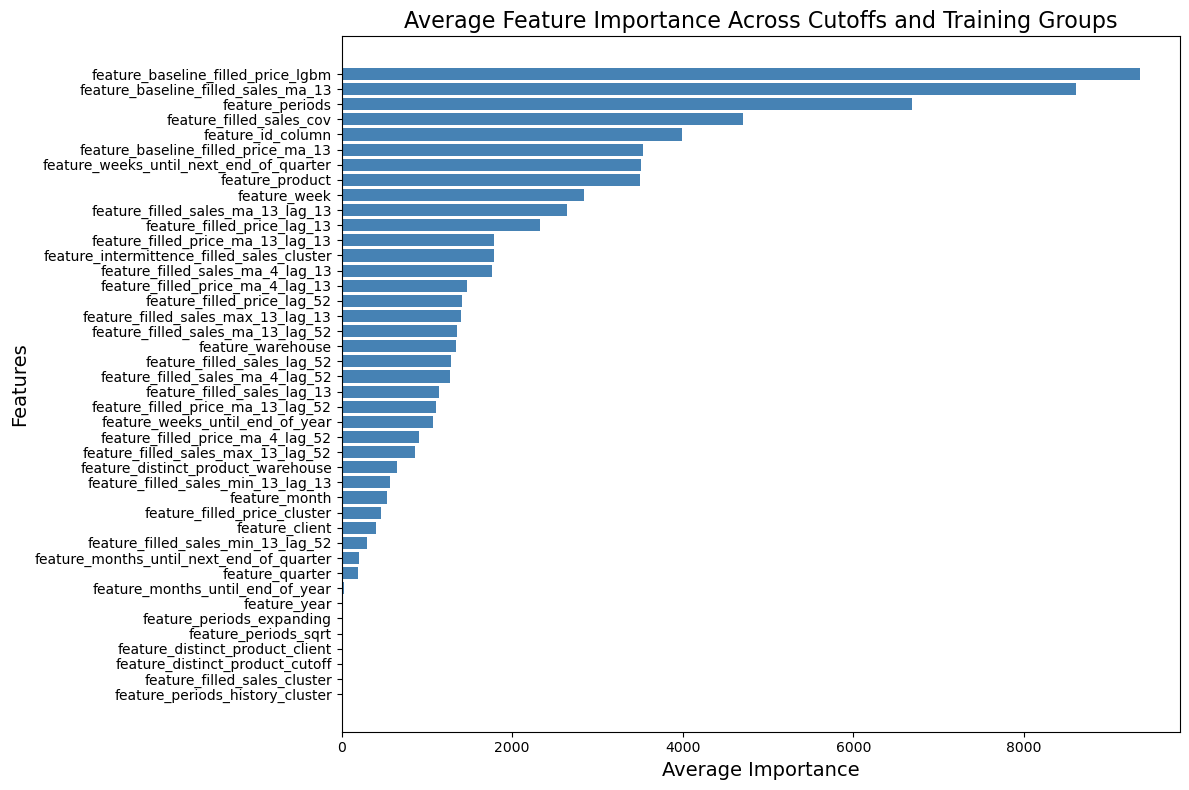

In [19]:
# Plot the average feature importance across all cutoffs
forecaster.plot_feature_importance()

## Run evaluator

In [20]:
# Params
actuals_col = 'sales'
baseline_col = 'baseline_filled_sales_ma_13'
preds_col = ['prediction']

# Initialize the Evaluator class
evaluator = Evaluator(df_with_preds, actuals_col, baseline_col, preds_col)

# Create and print metric table
metric_table = evaluator.create_metric_table()

# Show
metric_table

,RMSE,MAE,MAPE,WMAPE,Custom Metric
baseline_filled_sales_ma_13,78.84,27.42,137.24,60.21,90.33
prediction,64.27,22.79,131.43,50.03,64.40


# Plot predictions


In [21]:
# Get the max cutoff
max_cutoff = df_with_preds['cutoff'].max()

# Filter the DataFrame where cutoff is equal to the max cutoff
df_filtered = df_with_preds[df_with_preds['cutoff'] == max_cutoff]

# Show
df_filtered.head()

,client,warehouse,product,id_column,date,sales,price,filled_sales,filled_price,cutoff,sample,feature_client,feature_warehouse,feature_product,feature_id_column,feature_periods,feature_periods_expanding,feature_periods_sqrt,feature_year,feature_quarter,feature_month,feature_week,feature_weeks_until_next_end_of_quarter,feature_weeks_until_end_of_year,feature_months_until_next_end_of_quarter,feature_months_until_end_of_year,filled_sales_ma_4,filled_sales_ma_13,filled_price_ma_4,filled_price_ma_13,filled_sales_min_13,filled_sales_max_13,filled_price_min_13,filled_price_max_13,feature_filled_sales_lag_13,feature_filled_sales_lag_52,feature_filled_price_lag_13,feature_filled_price_lag_52,feature_filled_sales_ma_4_lag_13,feature_filled_sales_ma_4_lag_52,feature_filled_price_ma_4_lag_13,feature_filled_price_ma_4_lag_52,feature_filled_sales_ma_13_lag_13,feature_filled_sales_ma_13_lag_52,feature_filled_price_ma_13_lag_13,feature_filled_price_ma_13_lag_52,feature_filled_sales_min_13_lag_13,feature_filled_sales_min_13_lag_52,feature_filled_sales_max_13_lag_13,feature_filled_sales_max_13_lag_52,feature_filled_sales_cov,feature_distinct_product_client,feature_distinct_product_warehouse,feature_distinct_product_cutoff,feature_filled_sales_cluster,feature_filled_price_cluster,feature_periods_history_cluster,feature_intermittence_filled_sales_cluster,train_weight,feature_baseline_filled_sales_ma_13,feature_baseline_filled_price_ma_13,baseline_filled_sales_ma_13,baseline_filled_price_ma_13,baseline_filled_price_lgbm,feature_baseline_filled_price_lgbm,training_group,guardrail,prediction
1074576,1,235,13692,1/235/13692,2020-07-06,0.0,NaN,0.0,NaN,2024-01-01,train,0,10,658,62,0.0,0.0,0.0,2020,3,7,28,12,25,2,5,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.75,1,3,3,1,1,2,8,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1,False,NaN
1074577,1,235,4290,1/235/4290,2020-07-06,0.0,NaN,0.0,NaN,2024-01-01,train,0,10,1298,93,0.0,0.0,0.0,2020,3,7,28,12,25,2,5,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.75,1,2,3,1,1,2,8,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1,False,NaN
1074578,1,235,7350,1/235/7350,2020-07-06,0.0,NaN,0.0,NaN,2024-01-01,train,0,10,1893,113,0.0,0.0,0.0,2020,3,7,28,12,25,2,5,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.75,1,2,3,1,1,2,7,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1,False,NaN
1074579,1,235,8954,1/235/8954,2020-07-06,0.0,NaN,0.0,NaN,2024-01-01,train,0,10,2215,125,0.0,0.0,0.0,2020,3,7,28,12,25,2,5,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.49,1,2,3,1,1,2,10,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1,False,NaN
1074580,1,46,5731,1/46/5731,2020-07-06,0.0,NaN,0.0,NaN,2024-01-01,train,0,27,1547,168,0.0,0.0,0.0,2020,3,7,28,12,25,2,5,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.49,1,2,3,1,1,2,9,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1,False,NaN


In [22]:
# Params
baseline_col = 'baseline_filled_sales_ma_13'
top_n_plots = 6

## Plot by client

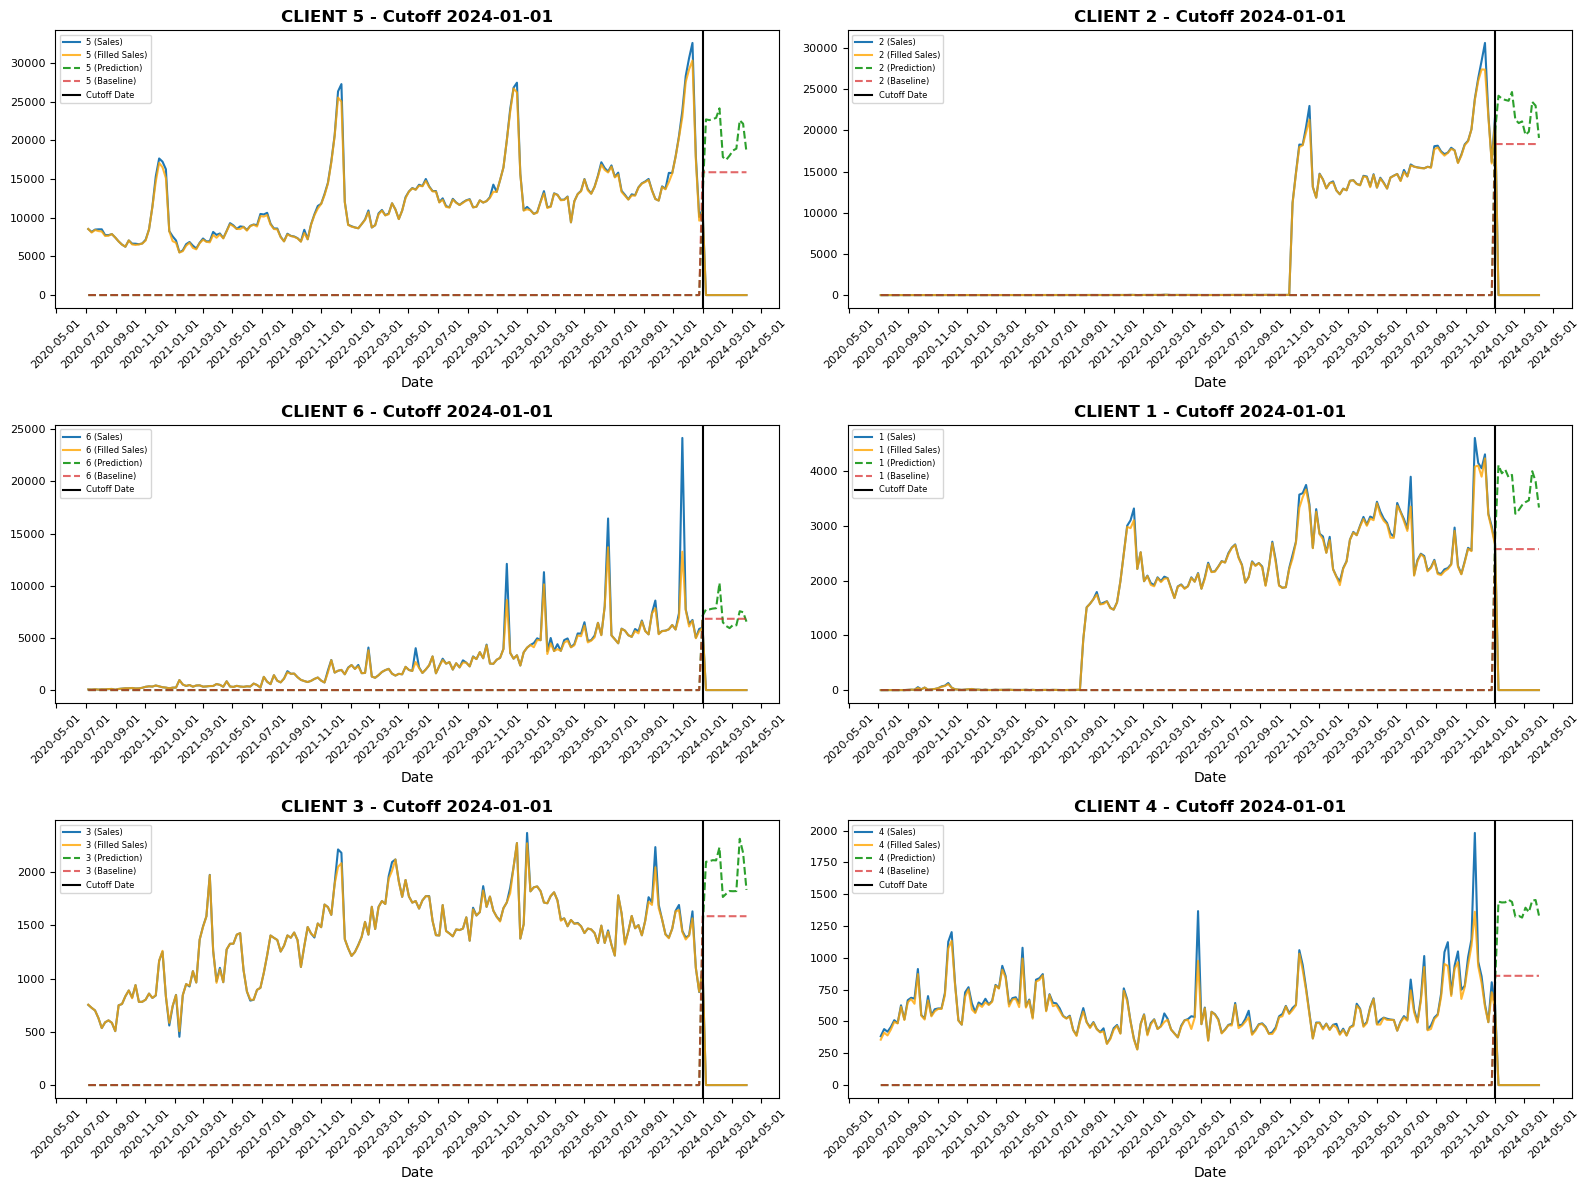

In [23]:
# Plot by client
process_and_plot(
    df_filtered,
    group_col='client',
    baseline_col=baseline_col,
    top_n=top_n_plots,
    title='Top Clients Sales vs Baseline vs Prediction'
)

## Plot by warehouse

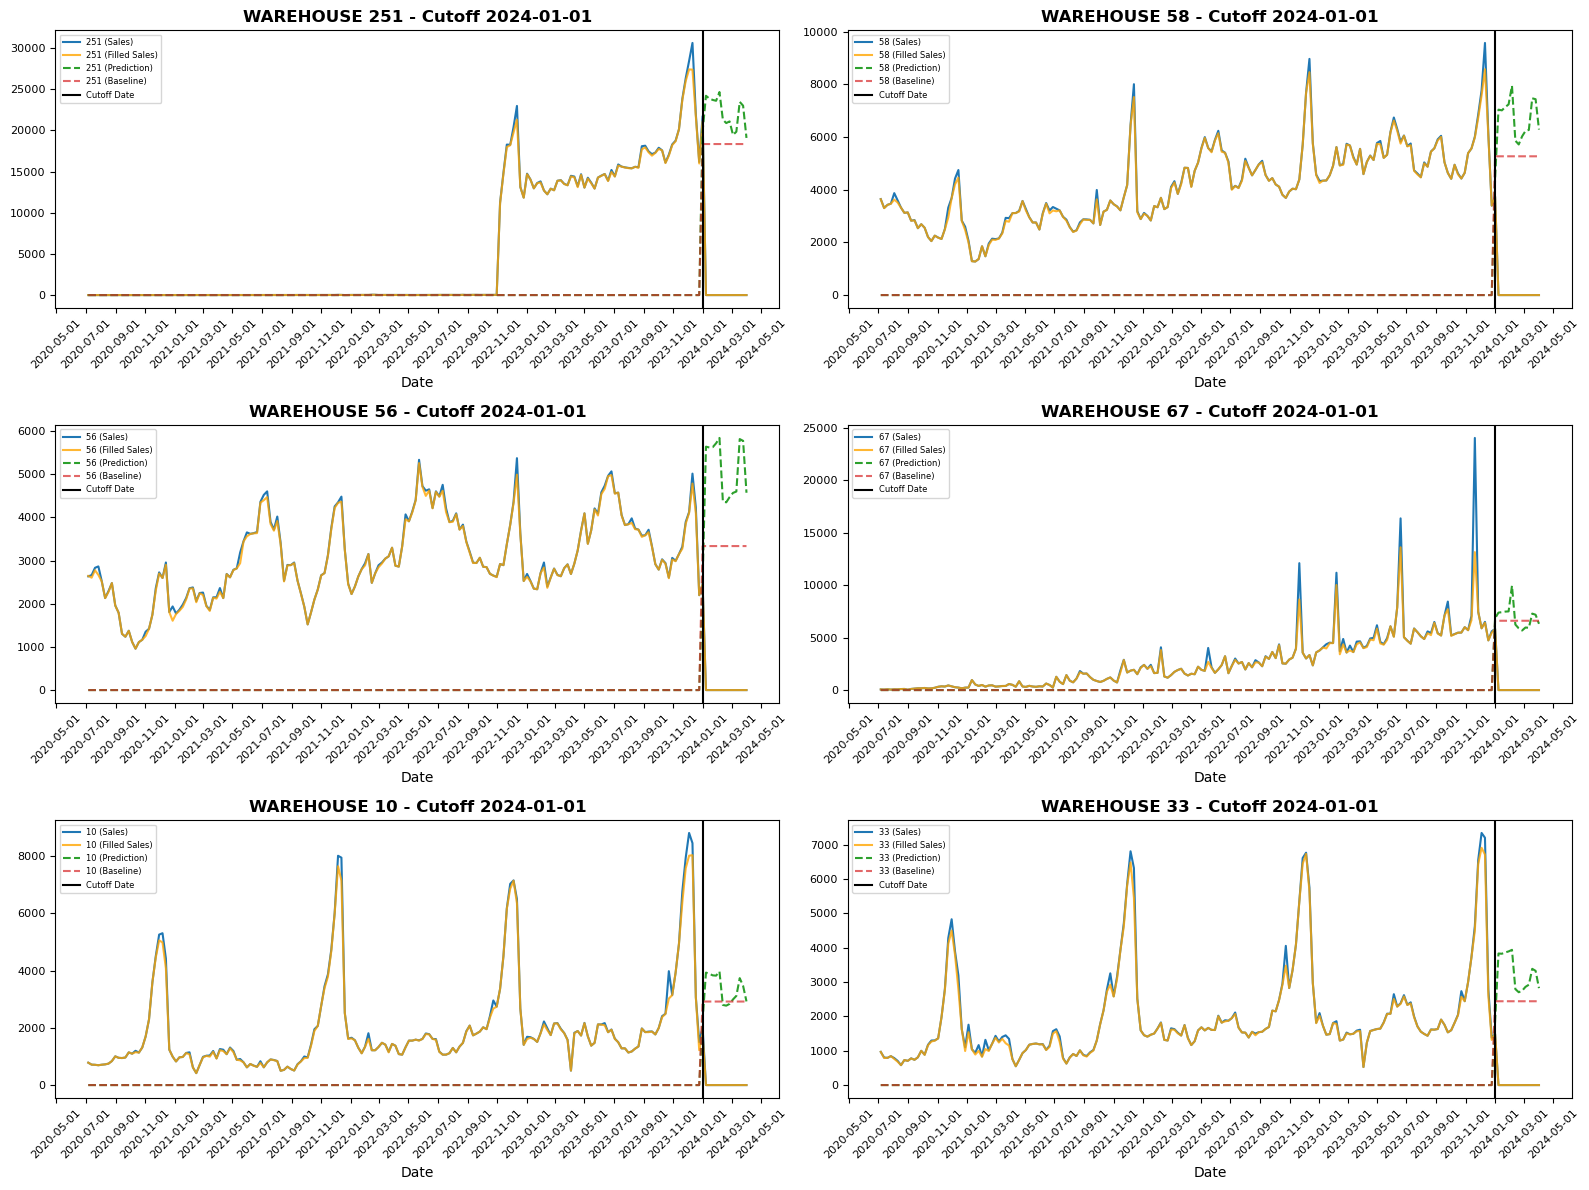

In [24]:
# Plot by warehouse
process_and_plot(
    df_filtered,
    group_col='warehouse',
    baseline_col=baseline_col,
    top_n=top_n_plots,
    title='Top Warehouses Sales vs Baseline vs Prediction'
)

## Plot by Product

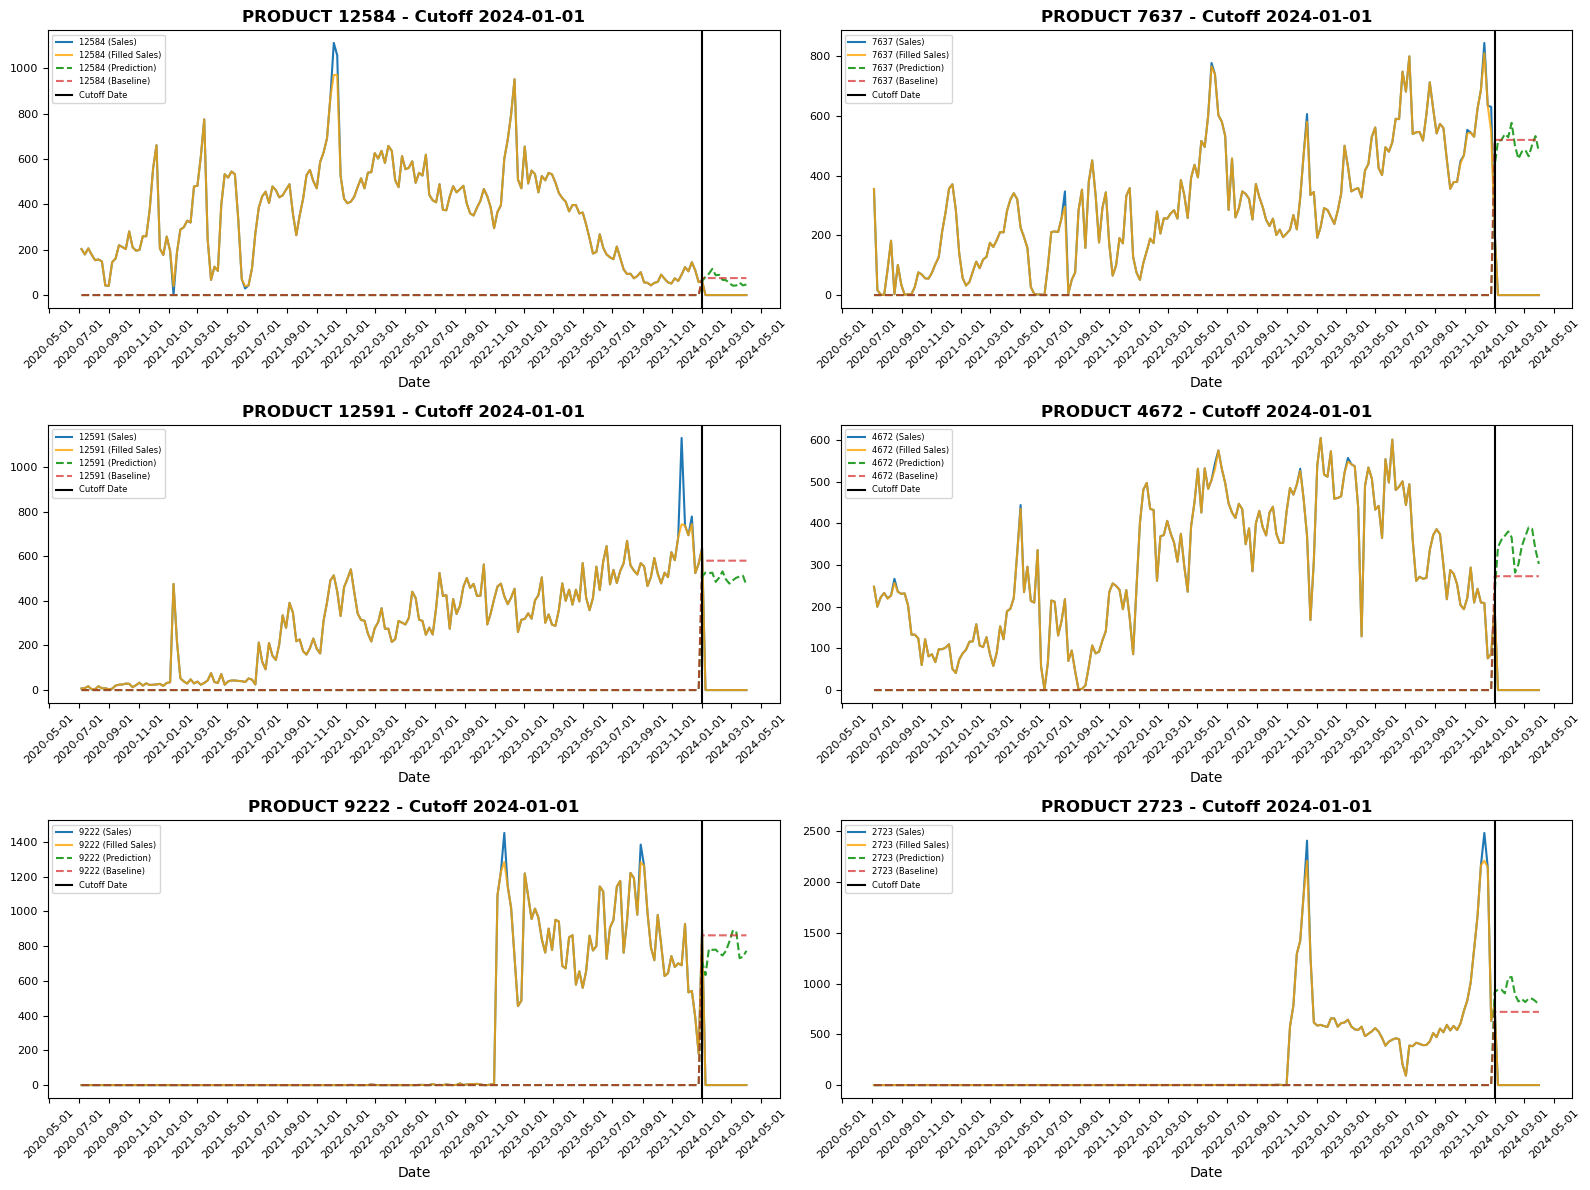

In [25]:
# Plot by product
process_and_plot(
    df_filtered,
    group_col='product',
    baseline_col=baseline_col,
    top_n=top_n_plots,
    title='Top Products Sales vs Baseline vs Prediction'
)

# Save output

In [26]:
# Create the filename with the phase appended
file_name = f'Data/df_lightgbm_preds.csv'

# Write the dataframe to the CSV file
df_with_preds.to_csv(file_name, index=False)

# Clean

In [27]:
# Garbage collection
gc.collect()

0